In [1]:
!pip install autocorrect emoji

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 622 kB 5.4 MB/s 
     |████████████████████████████████| 175 kB 60.7 MB/s 
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622382 sha256=7bb597f1349deca31c60b3b41b5826fd0009c10b38f193b597ea26a6b3e8d568
  Stored in directory: /root/.cache/pip/wheels/54/d4/37/8244101ad50b0f7d9bffd93ce58ed7991ee1753b290923934b
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171046 sha256=dad3dab298efa6203d676c6214d9d50bb12204807d97183989ae09a89bd33628
  Stored in directory: /root/.cache/pip/wheels/8a/4e/b6/57b01db010d17ef6ea9b40300af725ef3e210cb1acfb7ac8b6
Successfully built autocorrect emoji


In [2]:
import requests
from io import StringIO
import re
import nltk
import emoji
import pandas as pd
from autocorrect import Speller
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC, NuSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB, ComplementNB, MultinomialNB, GaussianNB
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier, SGDClassifier, Perceptron
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
data0 = pd.read_csv('drive/MyDrive/ML Mini Project/training.1600000.processed.noemoticon.csv', encoding = "ISO-8859-1", names=["sentiment", "ids", "date", "flag", "user", "text"])

In [6]:
data0

,sentiment,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
...,...,...,...,...,...,...
1599995,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599996,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599997,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599998,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [7]:
data1 = data0.copy()
data1 = data1[['sentiment', 'text']]

# Data cleaning
First of all we need to clean our text data, to do this we will create a function that removes not valuable staff, 
such as digits, emojis, links, punctuation and get lemma form of words

In [8]:
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip',
          '=^.^=': 'cat', ':D': 'smile', ';D': 'smile'}

In [9]:
def cleaner(tweet):
    for emoj in emojis.keys():
        if emoj in tweet:
            tweet = tweet.replace(emoj, "emoji" + emojis[emoj])
    tweet = tweet.lower()
    tweet = ''.join(c for c in tweet if not c.isdigit()) #remove digits
    tweet = re.sub("@[A-Za-z0-9]+","",tweet) #Remove @ sign
    tweet = re.sub(r"(?:\@|http?\://|https?\://|www)\S+", "", tweet) #Remove http links
    tweet = " ".join(tweet.split())
    tweet = ''.join(c for c in tweet if c not in emoji.UNICODE_EMOJI) #Remove Emojis
    tweet = tweet.replace("#", "").replace("_", " ") #Remove hashtag sign but keep the text
    tweet = ''.join(c for c in tweet if c not in punctuation) #remove all punctuation
    wordnet_lemmatizer = WordNetLemmatizer() # with use of morphological analysis of words
    tweet = [wordnet_lemmatizer.lemmatize(word) for word in nltk.word_tokenize(tweet)]
    tweet = " ".join(w for w in tweet)
    return tweet

In [10]:
data2 = data1.copy()
data2['text'] = data2['text'].apply(cleaner)

In [11]:
data2['text']

0          a thats a bummer you shoulda got david carr of...
1          is upset that he cant update his facebook by t...
2          i dived many time for the ball managed to save...
3               my whole body feel itchy and like it on fire
4          no it not behaving at all im mad why am i here...
                                 ...                        
1599995    just woke up having no school is the best feel...
1599996    thewdbcom very cool to hear old walt interview...
1599997    are you ready for your mojo makeover ask me fo...
1599998    happy th birthday to my boo of alll time tupac...
1599999                                 happy charitytuesday
Name: text, Length: 1600000, dtype: object

# Data transformation 
Now we need to transform data to sparse matrix and normalized with tf-idf representation.

CountVectorizer - produces a sparse representation of the counts

TfidfTransformer - Tf means term-frequency while tf-idf means term-frequency times inverse document-frequency

In [12]:
X = data2['text']
y = data2['sentiment']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Logistic Regression

In [13]:
vectorizer = CountVectorizer()
tfidf = TfidfTransformer()
clf = LogisticRegression(max_iter=100)

pipeline = Pipeline([
('vec', vectorizer),
('tfidf', tfidf),
('classifier', clf),
])

In [14]:
pipeline.fit(X_train, y_train) 
pred = pipeline.predict(X_test)
print(classification_report(y_test, pred))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


              precision    recall  f1-score   support

           0       0.80      0.79      0.79    159494
           4       0.79      0.81      0.80    160506

    accuracy                           0.80    320000
   macro avg       0.80      0.80      0.80    320000
weighted avg       0.80      0.80      0.80    320000



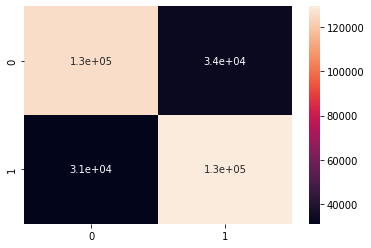

In [15]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True)

Linear SVC

In [16]:
vectorizer = CountVectorizer()
tfidf = TfidfTransformer()
clf = LinearSVC()

pipeline = Pipeline([
('vec', vectorizer),
('tfidf', tfidf),
('classifier', clf),
])

In [17]:
pipeline.fit(X_train, y_train) 
pred = pipeline.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.78      0.79    159494
           4       0.79      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



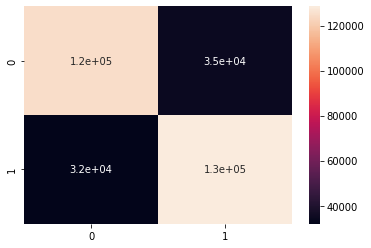

In [18]:
sns.heatmap(confusion_matrix(y_test, pred), annot=True)

K Nearest Neighbors

In [19]:
vectorizer = CountVectorizer()
tfidf = TfidfTransformer()
clf = KNeighborsClassifier(n_neighbors=5)

pipeline = Pipeline([
('vec', vectorizer),
('tfidf', tfidf),
('classifier', clf),
])

In [20]:
pipeline.fit(X_train[:10000], y_train[:10000]) 
pred = pipeline.predict(X_test[:10000])
print(classification_report(y_test[:10000], pred))

              precision    recall  f1-score   support

           0       0.54      0.53      0.54      5004
           4       0.54      0.55      0.54      4996

    accuracy                           0.54     10000
   macro avg       0.54      0.54      0.54     10000
weighted avg       0.54      0.54      0.54     10000



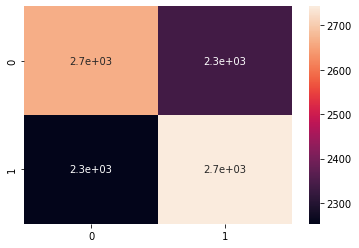

In [21]:
sns.heatmap(confusion_matrix(y_test[:10000], pred), annot=True)